In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle
#sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

#Infrastructure
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import NotFittedError

#Data Handling
from sklearn.utils.validation import (
    check_X_y,
    check_array,
    NotFittedError,
)
from sklearn.utils.multiclass import check_classification_targets

#Utils
import numpy as np

from tqdm import tqdm
from sklearn.base import clone 

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:

def _finite_sample_correction(posteriors, num_points_in_partition, num_classes):
    '''
    encourage posteriors to approach uniform when there is low data
    '''
    correction_constant = 1 / (num_classes * num_points_in_partition)

    zero_posterior_idxs = np.where(posteriors == 0)[0]

    c = len(zero_posterior_idxs) / (num_classes * num_points_in_partition)
    posteriors *= (1 - c)
    posteriors[zero_posterior_idxs] = correction_constant
    return posteriors

class UncertaintyForest(BaseEstimator, ClassifierMixin):
    '''
    based off of https://arxiv.org/pdf/1907.00325.pdf
    '''
    def __init__(
        self,
        max_depth=30,
        min_samples_leaf=1,
        max_samples = 0.32,
        max_features_tree = "auto",
        n_estimators=200,
        bootstrap=False,
        parallel=True):

        #Tree parameters.
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features_tree = max_features_tree

        #Bag parameters
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.max_samples = max_samples

        #Model parameters.
        self.parallel = parallel
        self.fitted = False

    def _check_fit(self):
        '''
        raise a NotFittedError if the model isn't fit
        '''
        if not self.fitted:
                msg = (
                        "This %(name)s instance is not fitted yet. Call 'fit' with "
                        "appropriate arguments before using this estimator."
                )
                raise NotFittedError(msg % {"name": type(self).__name__})

    def transform(self, X):
        '''
        get the estimated posteriors across trees
        '''
        X = check_array(X)
                
        def worker(tree_idx, tree):
            #get the nodes of X
            # Drop each estimation example down the tree, and record its 'y' value.
            return tree.apply(X)
            

        if self.parallel:
            return np.array(
                    Parallel(n_jobs=-1)(
                            delayed(worker)(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)
                    )
            )         
        else:
            return np.array(
                    [worker(tree_idx, tree) for tree_idx, tree in enumerate(self.ensemble.estimators_)]
                    )
        
    def get_transformer(self):
        return lambda X : self.transform(X)
        
    def vote(self, nodes_across_trees):
        return self.voter.predict(nodes_across_trees)
        
    def get_voter(self):
        return self.voter
        
                        
    def fit(self, X, y):

        #format X and y
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        
        #define the ensemble
        self.ensemble = BaggingClassifier(
            DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features_tree
            ),
            n_estimators=self.n_estimators,
            max_samples=self.max_samples,
            bootstrap=self.bootstrap,
            n_jobs = -1
        )
        
        #fit the ensemble
        self.ensemble.fit(X, y)
        
        class Voter(BaseEstimator):
            def __init__(self, estimators_samples_, classes, parallel = True):
                self.n_estimators = len(estimators_samples_)
                self.classes_ = classes
                self.parallel = parallel
                self.estimators_samples_ = estimators_samples_
            
            def fit(self, nodes_across_trees, y, fitting = False):
                self.tree_idx_to_node_ids_to_posterior_map = {}

                def worker(tree_idx):
                    nodes = nodes_across_trees[tree_idx]
                    cal_nodes = nodes[self.estimators_samples_[tree_idx]] if fitting else nodes
                    y_cal = y[self.estimators_samples_[tree_idx]] if fitting else y                    
                    
                    #create a map from the unique node ids to their classwise posteriors
                    node_ids_to_posterior_map = {}

                    #fill in the posteriors 
                    for node_id in np.unique(cal_nodes):
                        cal_idxs_of_node_id = np.where(cal_nodes == node_id)[0]
                        cal_ys_of_node = y_cal[cal_idxs_of_node_id]
                        class_counts = [len(np.where(cal_ys_of_node == y)[0]) for y in np.unique(y) ]
                        posteriors = np.nan_to_num(np.array(class_counts) / np.sum(class_counts))

                        #finite sample correction
                        posteriors_corrected = _finite_sample_correction(posteriors, len(cal_idxs_of_node_id), len(self.classes_))
                        node_ids_to_posterior_map[node_id] = posteriors_corrected

                    #add the node_ids_to_posterior_map to the overall tree_idx map 
                    self.tree_idx_to_node_ids_to_posterior_map[tree_idx] = node_ids_to_posterior_map
                    
                for tree_idx in range(self.n_estimators):
                        worker(tree_idx)
                return self
                        
                        
            def predict_proba(self, nodes_across_trees):
                def worker(tree_idx):
                    #get the node_ids_to_posterior_map for this tree
                    node_ids_to_posterior_map = self.tree_idx_to_node_ids_to_posterior_map[tree_idx]

                    #get the nodes of X
                    nodes = nodes_across_trees[tree_idx]

                    posteriors = []
                    node_ids = node_ids_to_posterior_map.keys()

                    #loop over nodes of X
                    for node in nodes:
                        #if we've seen this node before, simply get the posterior
                        if node in node_ids:
                            posteriors.append(node_ids_to_posterior_map[node])
                        #if we haven't seen this node before, simply use the uniform posterior 
                        else:
                            posteriors.append(np.ones((len(np.unique(self.classes_)))) / len(self.classes_))
                    return posteriors

                if self.parallel:
                    return np.mean(
                            Parallel(n_jobs=-1)(
                                    delayed(worker)(tree_idx) for tree_idx in range(self.n_estimators)
                            ), axis = 0
                    )

                else:
                    return np.mean(
                            [worker(tree_idx) for tree_idx in range(self.n_estimators)], axis = 0)
                
        #get the nodes of the calibration set
        nodes_across_trees = self.transform(X) 
        self.voter = Voter(estimators_samples_ = self.ensemble.estimators_samples_, classes = self.classes_, parallel = self.parallel)
        self.voter.fit(nodes_across_trees, y, fitting = True)
        self.fitted = True

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=-1)]

    def predict_proba(self, X):
        return self.voter.predict_proba(self.transform(X))




In [6]:
class LifeLongDNN():
    def __init__(self, acorn = None, verbose = False, model = "uf"):
        self.X_across_tasks = []
        self.y_across_tasks = []
        
        self.transformers_across_tasks = []
        
        #element [i, j] votes on decider from task i under representation from task j
        self.voters_across_tasks_matrix = []
        self.n_tasks = 0
        
        self.classes_across_tasks = []
        
        if acorn is not None:
            np.random.seed(acorn)
        
        self.verbose = verbose
        
        self.model = model
        
    def check_task_idx_(self, task_idx):
        if task_idx >= self.n_tasks:
            raise Exception("Invalid Task IDX")
    
    def new_forest(self, 
                   X, 
                   y, 
                   epochs = 100, 
                   lr = 5e-4, 
                   n_estimators = 10, 
                   max_samples = .63,
                   bootstrap = True,
                   max_depth = 30,
                   min_samples_leaf = 1,
                   acorn = None):
        
        #if self.model == "dnn":
        #    from honest_dnn import HonestDNN 
        #if self.model == "uf":
        #    from uncertainty_forest import UncertaintyForest
        
        self.X_across_tasks.append(X)
        self.y_across_tasks.append(y)
        
        if self.model == "dnn":
            new_honest_dnn = HonestDNN(verbose = self.verbose)
            new_honest_dnn.fit(X, y, epochs = epochs, lr = lr)
        if self.model == "uf":
            new_honest_dnn = UncertaintyForest(n_estimators = n_estimators,
                                               max_samples = max_samples,
                                               bootstrap = bootstrap,
                                               max_depth = max_depth,
                                               min_samples_leaf = min_samples_leaf,
                                               parallel = True)
            new_honest_dnn.fit(X, y)
        new_transformer = new_honest_dnn.get_transformer()
        new_voter = new_honest_dnn.get_voter()
        new_classes = new_honest_dnn.classes_
        
        self.transformers_across_tasks.append(new_transformer)
        self.classes_across_tasks.append(new_classes)
        
        #add one voter to previous task voter lists under the new transformation
        for task_idx in range(self.n_tasks):
            X_of_task, y_of_task = self.X_across_tasks[task_idx], self.y_across_tasks[task_idx]
            if self.model == "dnn":
                X_of_task_under_new_transform = new_transformer.predict(X_of_task) 
            if self.model == "uf":
                X_of_task_under_new_transform = new_transformer(X_of_task) 
            unfit_task_voter_under_new_transformation = clone(self.voters_across_tasks_matrix[task_idx][0])
            if self.model == "uf":
                unfit_task_voter_under_new_transformation.classes_ = self.voters_across_tasks_matrix[task_idx][0].classes_
            task_voter_under_new_transformation = unfit_task_voter_under_new_transformation.fit(X_of_task_under_new_transform, y_of_task)

            self.voters_across_tasks_matrix[task_idx].append(task_voter_under_new_transformation)
            
        #add n_tasks voters to new task voter list under previous transformations 
        new_voters_under_previous_task_transformation = []
        for task_idx in range(self.n_tasks):
            transformer_of_task = self.transformers_across_tasks[task_idx]
            if self.model == "dnn":
                X_under_task_transformation = transformer_of_task.predict(X)
            if self.model == "uf":
                X_under_task_transformation = transformer_of_task(X)
            unfit_new_task_voter_under_task_transformation = clone(new_voter)
            if self.model == "uf":
                unfit_new_task_voter_under_task_transformation.classes_ = new_voter.classes_
            new_task_voter_under_task_transformation = unfit_new_task_voter_under_task_transformation.fit(X_under_task_transformation, y)
            new_voters_under_previous_task_transformation.append(new_task_voter_under_task_transformation)
            
        #make sure to add the voter of the new task under its own transformation
        new_voters_under_previous_task_transformation.append(new_voter)
        
        self.voters_across_tasks_matrix.append(new_voters_under_previous_task_transformation)
        
        self.n_tasks += 1
        
    def _estimate_posteriors(self, X, representation = 0, decider = 0):
        self.check_task_idx_(decider)
        
        if representation == "all":
            representation = range(self.n_tasks)
        elif isinstance(representation, int):
            representation = np.array([representation])
        
        posteriors_across_tasks = []
        for transformer_task_idx in representation:
            transformer = self.transformers_across_tasks[transformer_task_idx]
            voter = self.voters_across_tasks_matrix[decider][transformer_task_idx]
            if self.model == "dnn":
                posteriors_across_tasks.append(voter.predict_proba(transformer.predict(X)))
            if self.model == "uf":
                posteriors_across_tasks.append(voter.predict_proba(transformer(X)))
        return np.mean(posteriors_across_tasks, axis = 0)
    
    def predict(self, X, representation = 0, decider = 0):
        task_classes = self.classes_across_tasks[decider]
        return task_classes[np.argmax(self._estimate_posteriors(X, representation, decider), axis = -1)]

In [28]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R


def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

In [9]:
def experiment(n_xor, n_nxor, n_test, reps=1, n_trees=1000, acorn=None):
    #print(1)
    if n_xor==0 and n_nxor==0:
        raise ValueError('Wake up and provide samples to train!!!')
    
    if acorn != None:
        np.random.seed(acorn)
    
    errors = np.zeros((reps,4),dtype=float)
    
    for i in range(reps):
        l2f = LifeLongDNN()
        #source data
        xor, label_xor = generate_gaussian_parity(n_xor,cov_scale=0.1,angle_params=0)
        test_xor, test_label_xor = generate_gaussian_parity(n_test,cov_scale=0.1,angle_params=0)
    
        #target data
        nxor, label_nxor = generate_gaussian_parity(n_nxor,cov_scale=0.1,angle_params=np.pi/2)
        test_nxor, test_label_nxor = generate_gaussian_parity(n_test,cov_scale=0.1,angle_params=np.pi/2)
    
        if n_xor == 0:
            l2f.new_forest(nxor, label_nxor, n_estimators=n_trees)
            
            errors[i,0] = 0.5
            errors[i,1] = 0.5
            
            uf_task2=l2f.predict(test_nxor, representation=0, decider=0)
            l2f_task2=l2f.predict(test_nxor, representation='all', decider=0)
            
            errors[i,2] = 1 - np.sum(uf_task2 == test_label_nxor)/n_test
            errors[i,3] = 1 - np.sum(l2f_task2 == test_label_nxor)/n_test
        elif n_nxor == 0:
            l2f.new_forest(xor, label_xor, n_estimators=n_trees)
            
            uf_task1=l2f.predict(test_xor, representation=0, decider=0)
            l2f_task1=l2f.predict(test_xor, representation='all', decider=0)
            
            errors[i,0] = 1 - np.sum(uf_task1 == test_label_xor)/n_test
            errors[i,1] = 1 - np.sum(l2f_task1 == test_label_xor)/n_test
            errors[i,2] = 0.5
            errors[i,3] = 0.5
        else:
            l2f.new_forest(xor, label_xor, n_estimators=n_trees)
            l2f.new_forest(nxor, label_nxor, n_estimators=n_trees)
            
            uf_task1=l2f.predict(test_xor, representation=0, decider=0)
            l2f_task1=l2f.predict(test_xor, representation='all', decider=0)
            uf_task2=l2f.predict(test_nxor, representation=1, decider=1)
            l2f_task2=l2f.predict(test_nxor, representation='all', decider=1)
            
            errors[i,0] = 1 - np.sum(uf_task1 == test_label_xor)/n_test
            errors[i,1] = 1 - np.sum(l2f_task1 == test_label_xor)/n_test
            errors[i,2] = 1 - np.sum(uf_task2 == test_label_nxor)/n_test
            errors[i,3] = 1 - np.sum(l2f_task2 == test_label_nxor)/n_test

    return np.mean(errors,axis=0)

In [13]:
mc_rep = 500
n_test = 1000
n_trees = 20
n_xor = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int)

mean_error = np.zeros((4, len(n_xor)+len(n_nxor)))
std_error = np.zeros((4, len(n_xor)+len(n_nxor)))

mean_te = np.zeros((2, len(n_xor)+len(n_nxor)))
std_te = np.zeros((2, len(n_xor)+len(n_nxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=40,verbose=1)(
        delayed(experiment)(n1,0,n_test,n_trees=n_trees) for _ in range(mc_rep)
    )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0]/error[:,1])
    mean_te[1,i] = np.mean(error[:,2]/error[:,3])
    std_te[0,i] = np.std(error[:,0]/error[:,1],ddof=1)
    std_te[1,i] = np.std(error[:,2]/error[:,3],ddof=1)
    
    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_nxor):
            print('starting to compute %s nxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=40,verbose=1)(
                delayed(experiment)(n1,n2,n_test,n_trees=n_trees) for _ in range(mc_rep)
            )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0]/error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2]/error[:,3])
            std_te[0,i+j+1] = np.std(error[:,0]/error[:,1],ddof=1)
            std_te[1,i+j+1] = np.std(error[:,2]/error[:,3],ddof=1)
            
with open('../result/mean_xor_nxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('../result/std_xor_nxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('../result/mean_te_xor_nxor.pickle','wb') as f:
    pickle.dump(mean_te,f)
    
with open('../result/std_te_xor_nxor.pickle','wb') as f:
    pickle.dump(std_te,f)

starting to compute 50 xor



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    5.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   10.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 75 xor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    3.1s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:    8.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   11.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 100 xor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    3.7s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   10.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   12.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 125 xor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    3.7s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   10.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   13.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 150 xor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    4.7s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   13.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   16.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 175 xor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    3.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   10.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   13.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 200 xor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    3.4s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   11.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 50 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.0s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   27.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   36.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 75 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   34.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 100 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   34.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 125 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   34.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 150 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.3s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   34.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 175 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.0s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   34.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 200 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.4s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   35.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 225 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.9s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   30.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   41.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 250 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   12.0s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   33.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   42.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 275 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   36.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 300 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   26.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   34.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 325 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   27.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   35.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 350 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.9s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   27.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   35.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 375 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   27.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   35.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 400 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   27.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   36.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 425 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.8s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   27.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   35.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 450 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.3s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   36.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 475 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   29.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   39.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 500 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   34.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   46.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 525 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   31.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   43.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 550 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.1s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   37.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 575 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    8.8s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   37.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 600 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.3s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   36.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 625 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   29.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   37.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 650 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   28.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   37.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 675 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   29.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   37.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 700 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   29.0s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   37.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 725 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   29.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   38.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 750 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   29.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   38.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 775 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.3s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   32.4s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   42.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 800 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.7s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   35.6s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   47.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 825 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   12.4s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   34.7s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   45.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 850 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   13.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   35.1s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   44.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 875 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   30.5s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   39.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 900 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   30.9s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   39.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 925 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.3s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   31.2s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   40.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 950 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   10.1s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   31.3s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   40.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 975 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   30.8s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   40.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


starting to compute 1000 nxor



[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:    9.6s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   31.3s
[Parallel(n_jobs=40)]: Done 500 out of 500 | elapsed:   40.8s finished


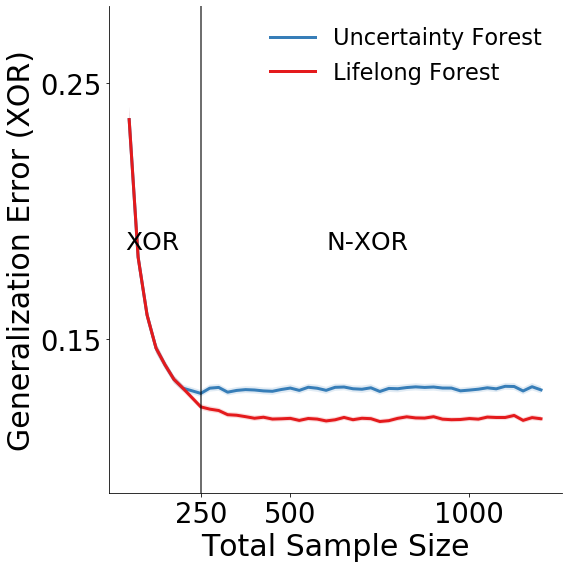

In [19]:
mc_rep = 500
mean_error = unpickle('../result/mean_xor_nxor.pickle')
std_error = unpickle('../result/std_xor_nxor.pickle')/np.sqrt(mc_rep)

n_xor = (100*np.arange(0.5, 2.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 10.25, step=0.25)).astype(int)

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['Uncertainty Forest', 'Lifelong Forest']


TASK1='XOR'
TASK2='N-XOR'

fontsize=30
labelsize=27.5

colors = sns.color_palette("Set1", n_colors = 2)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[0] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns, mean_error[1], label=algorithms[1], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.fill_between(ns, 
        mean_error[1] + 1.96*std_error[1, ], 
        mean_error[1] - 1.96*std_error[1, ], 
        where=mean_error[1] + 1.96*std_error[1] >= mean_error[1] - 1.96*std_error[1], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5, frameon=False)
ax1.set_ylim(0.09, 0.28)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([0.15, 0.25])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('../result/fig2_1.pdf',dpi=500)

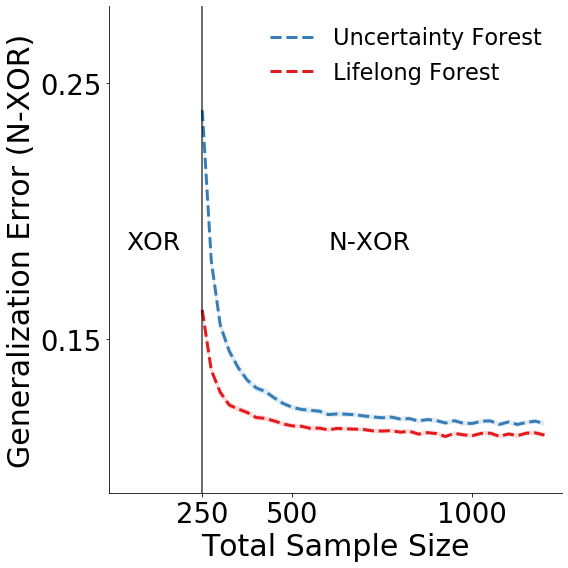

In [18]:
mean_error = unpickle('../result/mean_xor_nxor.pickle')
std_error = unpickle('../result/std_xor_nxor.pickle')/np.sqrt(mc_rep)

algorithms = ['Uncertainty Forest', 'Lifelong Forest']

TASK1='XOR'
TASK2='N-XOR'

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
# for i, algo in enumerate(algorithms):
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[0], c=colors[1], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[2, len(n1s):] + 1.96*std_error[2, len(n1s):], 
        mean_error[2, len(n1s):] - 1.96*std_error[2, len(n1s):], 
        where=mean_error[2, len(n1s):] + 1.96*std_error[2, len(n1s):] >= mean_error[2, len(n1s):] - 1.96*std_error[2, len(n1s):], 
        facecolor=colors[1], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[3, len(n1s):] + 1.96*std_error[3, len(n1s):], 
        mean_error[3, len(n1s):] - 1.96*std_error[3, len(n1s):], 
        where=mean_error[3, len(n1s):] + 1.96*std_error[3, len(n1s):] >= mean_error[3, len(n1s):] - 1.96*std_error[3, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5, frameon=False)
#         ax1.set_ylim(-0.01, 0.22)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
# ax1.set_yticks([0.15, 0.25, 0.35])
ax1.set_yticks([0.15, 0.25, 0.35])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)

ax1.set_ylim(0.09, 0.28)

ax1.set_xlim(-10)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

# ax1.set_ylim(0.14, 0.36)
ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('../result/fig2_2.pdf',dpi=500)

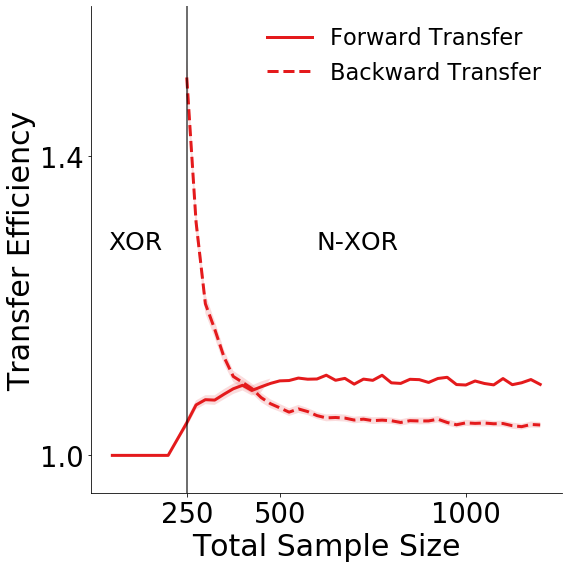

In [26]:
mean_error = unpickle('../result/mean_te_xor_nxor.pickle')
std_error = unpickle('../result/std_te_xor_nxor.pickle')/np.sqrt(mc_rep)

algorithms = ['Forward Transfer', 'Backward Transfer']

TASK1='XOR'
TASK2='N-XOR'

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)

ax1.plot(ns, mean_error[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.fill_between(ns, 
        mean_error[0] + 1.96*std_error[0], 
        mean_error[0] - 1.96*std_error[0], 
        where=mean_error[1] + 1.96*std_error[0] >= mean_error[0] - 1.96*std_error[0], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.plot(ns[len(n1s):], mean_error[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.fill_between(ns[len(n1s):], 
        mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):], 
        mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        where=mean_error[1, len(n1s):] + 1.96*std_error[1, len(n1s):] >= mean_error[1, len(n1s):] - 1.96*std_error[1, len(n1s):], 
        facecolor=colors[0], 
        alpha=0.15,
        interpolate=True)

ax1.set_ylabel('Transfer Efficiency', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=22.5, frameon=False)
ax1.set_ylim(0.95, 1.6)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_yticks([1, 1.4])
ax1.set_xticks([250, 500, 1000])
ax1.axvline(x=ns[len(n1s)], c='k', alpha=0.75)
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(40, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=25)
ax1.text(600, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=25)

plt.tight_layout()

plt.savefig('../result/fig2_3.pdf',dpi=500)

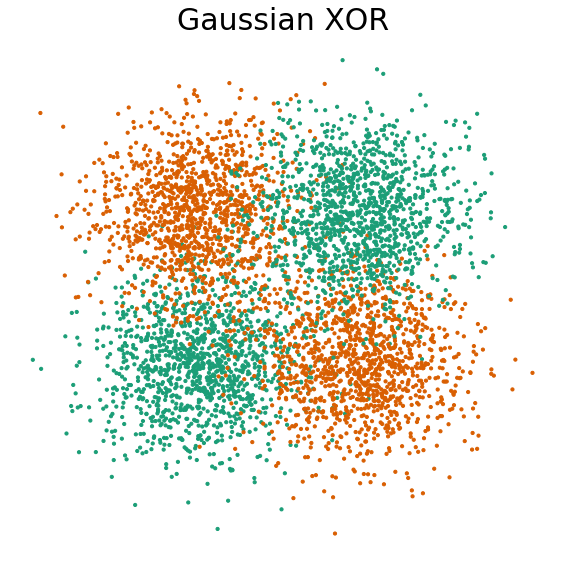

In [33]:
colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=0)
Z, W = generate_gaussian_parity(5000, cov_scale=0.1, angle_params=np.pi/2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:, 0], X[:, 1], c=get_colors(colors, Y), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

plt.tight_layout()
ax.axis('off')
plt.savefig('../result/gaussian-xor.pdf')

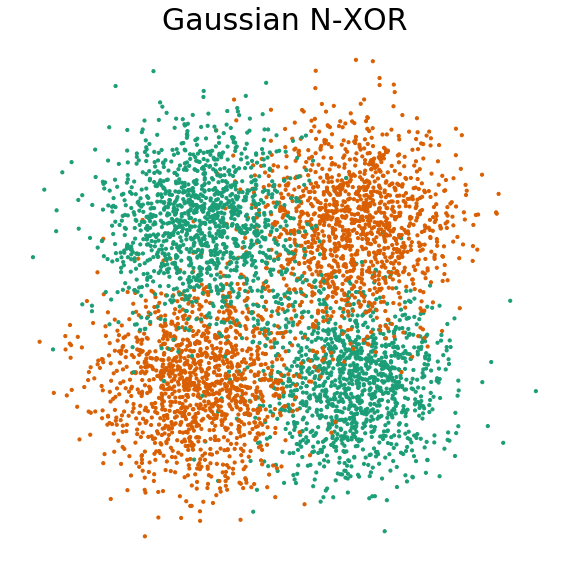

In [37]:
colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(Z[:, 0], Z[:, 1], c=get_colors(colors, W), s=10)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian N-XOR', fontsize=30)
ax.axis('off')
plt.tight_layout()
plt.savefig('../result/gaussian-nxor.pdf')